In [1]:
!pip install -q numerapi lightgbm pyarrow scikit-learn scipy matplotlib
# make sure you restart your kernel session before continuing


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from numerapi import NumerAPI
import pandas as pd

DATASET_VERSION = 'v2.1'

napi = NumerAPI()

In [3]:
napi.download_dataset(f'signals/{DATASET_VERSION}/train.parquet')
napi.download_dataset(f'signals/{DATASET_VERSION}/validation.parquet')

2025-09-26 16:17:29,701 INFO numerapi.utils: target file already exists


2025-09-26 16:17:29,703 INFO numerapi.utils: download complete


2025-09-26 16:17:30,446 INFO numerapi.utils: target file already exists


2025-09-26 16:17:30,448 INFO numerapi.utils: download complete


'signals/v2.1/validation.parquet'

In [4]:
train = pd.read_parquet(f'signals/{DATASET_VERSION}/train.parquet')
validation = pd.read_parquet(f'signals/{DATASET_VERSION}/validation.parquet')

# Tickers

The Signals dataset contains two tickers: `numerai_ticker` and `composite_figi`:
- `numerai_ticker` is given for the entire history
- `composite_figi` only goes back to September 2022.

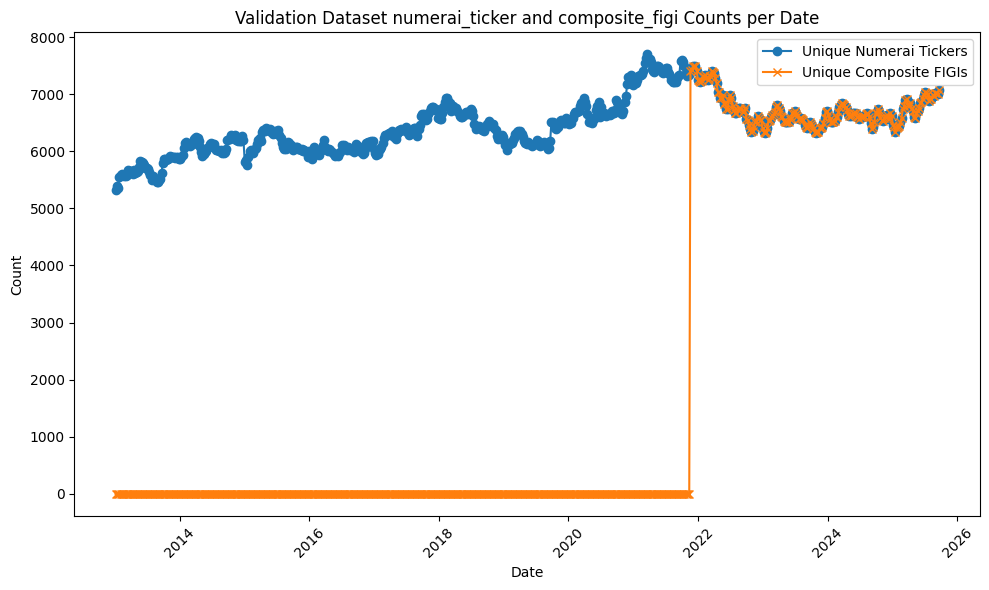

In [5]:
import matplotlib.pyplot as plt

def plot_ticker_counts_per_date(df, title):
    df['date'] = pd.to_datetime(df['date'])

    # Count unique 'numerai_ticker' and 'composite_figi' per 'date'
    nticker_count_per_date = df.groupby('date')['numerai_ticker'].nunique().reset_index(name='numerai_ticker_count')
    figi_count_per_date = df.groupby('date')['composite_figi'].nunique().reset_index(name='figi_count')

    # Merge the counts into a single DataFrame for plotting
    merged_counts = pd.merge(nticker_count_per_date, figi_count_per_date, on='date')

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(merged_counts['date'], merged_counts['numerai_ticker_count'], label='Unique Numerai Tickers', marker='o')
    plt.plot(merged_counts['date'], merged_counts['figi_count'], label='Unique Composite FIGIs', marker='x')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_ticker_counts_per_date(validation, 'Validation Dataset numerai_ticker and composite_figi Counts per Date')

If you have Bloomberg tickers, you can map to `numerai_ticker` by replacing the exchange code with the ISO country code

In [6]:
import random

# Computed using https://stockmarketmba.com/globalstockexchanges.php
# and https://www.isin.net/country-codes/
# Converting Bloomberg exchange code -> Country -> ISO 3166
TICKER_CTRY_MAP = {
    "AU": "AU", "AV": "AT", "BB": "BE", "BZ": "BR", "CA": "CA",
    "CB": "CO", "CH": "CN", "CI": "CL", "CN": "CA", "CP": "CZ",
    "DC": "DK", "EY": "EG", "FH": "FI", "FP": "FR", "GA": "GR",
    "GR": "DE", "GY": "DE", "HB": "HU", "HK": "HK", "ID": "IE",
    "IJ": "ID", "IM": "IT", "IN": "IN", "IT": "IL", "JP": "JP",
    "KS": "KR", "LN": "GB", "MF": "MX", "MK": "MY", "NA": "NL",
    "NO": "NO", "NZ": "NZ", "PE": "PE", "PL": "PT", "PM": "PH",
    "PW": "PL", "QD": "QA", "RM": "RU", "SJ": "ZA", "SM": "ES",
    "SP": "SG", "SS": "SE", "SW": "CH", "TB": "TH", "TI": "TR",
    "TT": "TW", "UH": "AE", "US": "US", "UQ": "US",
}

def map_country_code(row):
    if row["bloomberg_ticker"] is None:
        return None
    split_ticker = row["bloomberg_ticker"].split()
    if len(split_ticker) < 2:
        print(f'No country code for {row["bloomberg_ticker"]}')
        return None

    ticker = split_ticker[0]
    country_code = split_ticker[-1]
    iso_country_code = TICKER_CTRY_MAP.get(country_code)
    return f"{ticker} {iso_country_code}"

# create test dataframe with Bloomberg tickers
df = pd.DataFrame([
  {'bloomberg_ticker': '000640 KS', 'signal': random.random()},
  {'bloomberg_ticker': '1103 TT', 'signal': random.random()},
  {'bloomberg_ticker': 'A2A IM', 'signal': random.random()},
  {'bloomberg_ticker': 'ABBN SW', 'signal': random.random()}
])

# convert to numerai_ticker
df['numerai_ticker'] = df.apply(
    map_country_code, axis=1
)

assert df.iloc[0]['numerai_ticker'] == '000640 KR'
assert df.iloc[1]['numerai_ticker'] == '1103 TW'
assert df.iloc[2]['numerai_ticker'] == 'A2A IT'
assert df.iloc[3]['numerai_ticker'] == 'ABBN CH'

# Features

Features with `{n}(d|w)` in the name (for example, `feature_adv_20d_factor`) are time-series features that are computed over `n` days or `n` weeks.

Features with `country_ranknorm` in the name are grouped by country, then ranked, then gaussianized.

Features with `factor` in the name refer to risk factors that most of the targets are neutral to.

PPO, RSI and TRIX are examples of technical indicators.

PPO is a percentage price oscillator that compares shorter and longer moving averages in a ratio
RSI is the relative strength index usually used as an overbought/oversold indicator
TRIX is a triple exponential moving average indicator usually used as momentum or reversal feature

`momentum_52w_less_4w` refers to one year return of a stock excluding the last 4 weeks.



In [7]:
train.filter(like="feature_").columns.tolist()

['feature_country',
 'feature_adv_20d_factor',
 'feature_beta_factor',
 'feature_book_to_price_factor',
 'feature_dividend_yield_factor',
 'feature_earnings_yield_factor',
 'feature_growth_factor',
 'feature_impact_cost_factor',
 'feature_market_cap_factor',
 'feature_momentum_12w_factor',
 'feature_momentum_26w_factor',
 'feature_momentum_52w_factor',
 'feature_momentum_52w_less_4w_factor',
 'feature_ppo_60d_130d_country_ranknorm',
 'feature_ppo_60d_90d_country_ranknorm',
 'feature_price_factor',
 'feature_rsi_130d_country_ranknorm',
 'feature_rsi_60d_country_ranknorm',
 'feature_rsi_90d_country_ranknorm',
 'feature_trix_130d_country_ranknorm',
 'feature_trix_60d_country_ranknorm',
 'feature_value_factor',
 'feature_volatility_factor']

# Modeling

The dataset includes a small set of features that can be used on its own or in addition to your existing dataset. In this example, we will show how to use the V1 features to train and submit predictions.

In [8]:
import lightgbm as lgb

feature_cols = [col for col in train.columns if col.startswith('feature_')]

# there are two non-numerical feature cols
feature_cols = [s for s in feature_cols if s not in ("feature_country", "feature_exchange_code")]

# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)

# This will take a few minutes 🍵
model.fit(
  train[feature_cols],
  train["target_chili_60"]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 2536318, number of used features: 22
[LightGBM] [Info] Start training from score 0.426373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.01
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# Scores

Signals uses `alpha` and `meta portfolio contribution` to determine the performance of a signal. These can be calculated with functions from our open-source `numerai-tools` package.

First, let's download the required data:

In [9]:
napi.download_dataset(f'signals/{DATASET_VERSION}/validation_neutralizer.parquet')
napi.download_dataset(f'signals/{DATASET_VERSION}/validation_sample_weights.parquet')

2025-09-26 16:17:58,156 INFO numerapi.utils: target file already exists


2025-09-26 16:17:58,158 INFO numerapi.utils: download complete


2025-09-26 16:17:58,642 INFO numerapi.utils: target file already exists


2025-09-26 16:17:58,644 INFO numerapi.utils: download complete


'signals/v2.1/validation_sample_weights.parquet'

Then, we can use this data to calculate alpha over the validation period.

In [10]:
# filter out NaN 60D targets at the end of the validation set
#  the rest should be filled
validation = validation.dropna(subset=["target_chili_60"]).set_index("numerai_ticker")

In [11]:
!pip install -q --no-deps numerai-tools


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [12]:
from tqdm import tqdm
from numerai_tools.scoring import alpha, center, filter_sort_index_many

# read neutralizers and sample weights and format their date columns
sample_weights = (
    pd.read_parquet(f'signals/{DATASET_VERSION}/validation_sample_weights.parquet')
    .set_index("numerai_ticker")
)
sample_weights["date"] = pd.to_datetime(sample_weights["date"])

alpha_scores = {}

for date, group in tqdm(
    validation.groupby("date"),
    total=validation["date"].nunique()
):
    # first, predict on the validation set
    predictions = pd.DataFrame(
        model.predict(group[feature_cols]),
        index=group.index,
        columns=["prediction"],
    )

    # then gather neutralizers and sample weights
    # the neutralizers are very big, so to reduce memory usage, we
    #  use parquet predicate filters to only load the relevant date
    neutralizers = (
        pd.read_parquet(
            f'signals/{DATASET_VERSION}/validation_neutralizer.parquet',
            filters=[("date", "=", date.strftime("%Y-%m-%d"))],
        ) # then set the index, filter to only the neutralizers, and drop NaNs
        .set_index("numerai_ticker")
        .filter(like="neutralizer_")
        .dropna(axis=0, how="all")
    )

    # get sample weights for this date, drop NaNs
    weights = (
        sample_weights.loc[sample_weights.date == date, "sample_weights"]
        .dropna()
    )

    # align and sort all datasets by common ticker index
    predictions, neutralizers, weights, targets = filter_sort_index_many([
        predictions,
        neutralizers,
        weights,
        group["target_chili_60"],
    ])

    # finally, calculate alpha
    alpha_score = alpha(
        predictions=predictions,
        neutralizers=neutralizers,
        sample_weights=weights,
        targets=targets,
    )

    alpha_scores[date] = alpha_score


  0%|          | 0/651 [00:00<?, ?it/s]

  0%|          | 1/651 [00:01<12:00,  1.11s/it]

  0%|          | 2/651 [00:01<07:31,  1.44it/s]

  0%|          | 3/651 [00:01<06:20,  1.70it/s]

  1%|          | 4/651 [00:02<05:23,  2.00it/s]

  1%|          | 5/651 [00:02<05:00,  2.15it/s]

  1%|          | 6/651 [00:03<04:42,  2.28it/s]

  1%|          | 7/651 [00:03<04:29,  2.39it/s]

  1%|          | 8/651 [00:03<04:19,  2.48it/s]

  1%|▏         | 9/651 [00:04<04:14,  2.52it/s]

  2%|▏         | 10/651 [00:04<04:11,  2.55it/s]

  2%|▏         | 11/651 [00:05<04:08,  2.57it/s]

  2%|▏         | 12/651 [00:05<04:09,  2.56it/s]

  2%|▏         | 13/651 [00:05<04:06,  2.58it/s]

  2%|▏         | 14/651 [00:06<04:01,  2.64it/s]

  2%|▏         | 15/651 [00:06<03:57,  2.67it/s]

  2%|▏         | 16/651 [00:06<03:57,  2.68it/s]

  3%|▎         | 17/651 [00:07<03:55,  2.69it/s]

  3%|▎         | 18/651 [00:07<03:56,  2.68it/s]

  3%|▎         | 19/651 [00:08<03:56,  2.67it/s]

  3%|▎         | 20/651 [00:08<03:54,  2.69it/s]

  3%|▎         | 21/651 [00:08<03:56,  2.67it/s]

  3%|▎         | 22/651 [00:09<03:55,  2.67it/s]

  4%|▎         | 23/651 [00:09<03:55,  2.67it/s]

  4%|▎         | 24/651 [00:09<03:56,  2.65it/s]

  4%|▍         | 25/651 [00:10<03:58,  2.62it/s]

  4%|▍         | 26/651 [00:10<04:12,  2.47it/s]

  4%|▍         | 27/651 [00:11<04:07,  2.52it/s]

  4%|▍         | 28/651 [00:11<04:00,  2.59it/s]

  4%|▍         | 29/651 [00:11<04:00,  2.58it/s]

  5%|▍         | 30/651 [00:12<03:57,  2.62it/s]

  5%|▍         | 31/651 [00:12<03:55,  2.63it/s]

  5%|▍         | 32/651 [00:12<03:50,  2.69it/s]

  5%|▌         | 33/651 [00:13<03:47,  2.72it/s]

  5%|▌         | 34/651 [00:13<03:42,  2.77it/s]

  5%|▌         | 35/651 [00:14<03:44,  2.74it/s]

  6%|▌         | 36/651 [00:14<03:46,  2.72it/s]

  6%|▌         | 37/651 [00:14<03:45,  2.73it/s]

  6%|▌         | 38/651 [00:15<03:48,  2.69it/s]

  6%|▌         | 39/651 [00:15<03:51,  2.64it/s]

  6%|▌         | 40/651 [00:15<03:50,  2.65it/s]

  6%|▋         | 41/651 [00:16<03:48,  2.67it/s]

  6%|▋         | 42/651 [00:16<03:46,  2.69it/s]

  7%|▋         | 43/651 [00:17<03:46,  2.69it/s]

  7%|▋         | 44/651 [00:17<03:45,  2.70it/s]

  7%|▋         | 45/651 [00:17<03:45,  2.69it/s]

  7%|▋         | 46/651 [00:18<03:46,  2.67it/s]

  7%|▋         | 47/651 [00:18<03:44,  2.69it/s]

  7%|▋         | 48/651 [00:18<03:43,  2.70it/s]

  8%|▊         | 49/651 [00:19<03:36,  2.78it/s]

  8%|▊         | 50/651 [00:19<03:37,  2.76it/s]

  8%|▊         | 51/651 [00:19<03:42,  2.70it/s]

  8%|▊         | 52/651 [00:20<03:45,  2.66it/s]

  8%|▊         | 53/651 [00:20<03:42,  2.69it/s]

  8%|▊         | 54/651 [00:21<03:44,  2.66it/s]

  8%|▊         | 55/651 [00:21<03:41,  2.69it/s]

  9%|▊         | 56/651 [00:21<03:40,  2.70it/s]

  9%|▉         | 57/651 [00:22<03:38,  2.72it/s]

  9%|▉         | 58/651 [00:22<03:39,  2.70it/s]

  9%|▉         | 59/651 [00:22<03:38,  2.71it/s]

  9%|▉         | 60/651 [00:23<03:36,  2.73it/s]

  9%|▉         | 61/651 [00:23<03:36,  2.72it/s]

 10%|▉         | 62/651 [00:24<03:37,  2.71it/s]

 10%|▉         | 63/651 [00:24<03:38,  2.69it/s]

 10%|▉         | 64/651 [00:24<03:41,  2.65it/s]

 10%|▉         | 65/651 [00:25<03:43,  2.63it/s]

 10%|█         | 66/651 [00:25<03:38,  2.67it/s]

 10%|█         | 67/651 [00:25<03:39,  2.66it/s]

 10%|█         | 68/651 [00:26<03:39,  2.66it/s]

 11%|█         | 69/651 [00:26<03:38,  2.66it/s]

 11%|█         | 70/651 [00:27<03:38,  2.66it/s]

 11%|█         | 71/651 [00:27<03:38,  2.66it/s]

 11%|█         | 72/651 [00:27<03:35,  2.69it/s]

 11%|█         | 73/651 [00:28<03:34,  2.70it/s]

 11%|█▏        | 74/651 [00:28<03:34,  2.70it/s]

 12%|█▏        | 75/651 [00:28<03:35,  2.67it/s]

 12%|█▏        | 76/651 [00:29<03:34,  2.68it/s]

 12%|█▏        | 77/651 [00:29<03:36,  2.65it/s]

 12%|█▏        | 78/651 [00:30<03:36,  2.65it/s]

 12%|█▏        | 79/651 [00:30<03:34,  2.67it/s]

 12%|█▏        | 80/651 [00:30<03:34,  2.66it/s]

 12%|█▏        | 81/651 [00:31<03:35,  2.65it/s]

 13%|█▎        | 82/651 [00:31<03:33,  2.66it/s]

 13%|█▎        | 83/651 [00:31<03:34,  2.64it/s]

 13%|█▎        | 84/651 [00:32<03:32,  2.66it/s]

 13%|█▎        | 85/651 [00:32<03:33,  2.66it/s]

 13%|█▎        | 86/651 [00:33<03:32,  2.66it/s]

 13%|█▎        | 87/651 [00:33<03:31,  2.67it/s]

 14%|█▎        | 88/651 [00:33<03:32,  2.65it/s]

 14%|█▎        | 89/651 [00:34<03:32,  2.65it/s]

 14%|█▍        | 90/651 [00:34<03:31,  2.65it/s]

 14%|█▍        | 91/651 [00:34<03:32,  2.64it/s]

 14%|█▍        | 92/651 [00:35<03:33,  2.62it/s]

 14%|█▍        | 93/651 [00:35<03:32,  2.63it/s]

 14%|█▍        | 94/651 [00:36<03:33,  2.61it/s]

 15%|█▍        | 95/651 [00:36<03:34,  2.60it/s]

 15%|█▍        | 96/651 [00:36<03:41,  2.50it/s]

 15%|█▍        | 97/651 [00:37<03:45,  2.45it/s]

 15%|█▌        | 98/651 [00:37<03:43,  2.47it/s]

 15%|█▌        | 99/651 [00:38<03:46,  2.43it/s]

 15%|█▌        | 100/651 [00:38<03:39,  2.51it/s]

 16%|█▌        | 101/651 [00:38<03:33,  2.58it/s]

 16%|█▌        | 102/651 [00:39<03:34,  2.56it/s]

 16%|█▌        | 103/651 [00:39<03:29,  2.62it/s]

 16%|█▌        | 104/651 [00:40<03:35,  2.54it/s]

 16%|█▌        | 105/651 [00:40<03:45,  2.42it/s]

 16%|█▋        | 106/651 [00:40<03:40,  2.47it/s]

 16%|█▋        | 107/651 [00:41<03:35,  2.52it/s]

 17%|█▋        | 108/651 [00:41<03:32,  2.55it/s]

 17%|█▋        | 109/651 [00:42<03:34,  2.52it/s]

 17%|█▋        | 110/651 [00:42<03:30,  2.57it/s]

 17%|█▋        | 111/651 [00:42<03:29,  2.57it/s]

 17%|█▋        | 112/651 [00:43<03:32,  2.54it/s]

 17%|█▋        | 113/651 [00:43<03:28,  2.58it/s]

 18%|█▊        | 114/651 [00:44<03:24,  2.63it/s]

 18%|█▊        | 115/651 [00:44<03:22,  2.65it/s]

 18%|█▊        | 116/651 [00:44<03:20,  2.66it/s]

 18%|█▊        | 117/651 [00:45<03:20,  2.67it/s]

 18%|█▊        | 118/651 [00:45<03:21,  2.64it/s]

 18%|█▊        | 119/651 [00:45<03:22,  2.63it/s]

 18%|█▊        | 120/651 [00:46<03:21,  2.63it/s]

 19%|█▊        | 121/651 [00:46<03:20,  2.64it/s]

 19%|█▊        | 122/651 [00:47<03:24,  2.59it/s]

 19%|█▉        | 123/651 [00:47<03:22,  2.61it/s]

 19%|█▉        | 124/651 [00:47<03:23,  2.59it/s]

 19%|█▉        | 125/651 [00:48<03:22,  2.59it/s]

 19%|█▉        | 126/651 [00:48<03:24,  2.57it/s]

 20%|█▉        | 127/651 [00:49<03:22,  2.58it/s]

 20%|█▉        | 128/651 [00:49<03:19,  2.62it/s]

 20%|█▉        | 129/651 [00:49<03:18,  2.63it/s]

 20%|█▉        | 130/651 [00:50<03:15,  2.66it/s]

 20%|██        | 131/651 [00:50<03:17,  2.64it/s]

 20%|██        | 132/651 [00:50<03:18,  2.62it/s]

 20%|██        | 133/651 [00:51<03:17,  2.62it/s]

 21%|██        | 134/651 [00:51<03:17,  2.62it/s]

 21%|██        | 135/651 [00:52<03:13,  2.66it/s]

 21%|██        | 136/651 [00:52<03:12,  2.68it/s]

 21%|██        | 137/651 [00:52<03:11,  2.68it/s]

 21%|██        | 138/651 [00:53<03:11,  2.68it/s]

 21%|██▏       | 139/651 [00:53<03:11,  2.67it/s]

 22%|██▏       | 140/651 [00:53<03:10,  2.69it/s]

 22%|██▏       | 141/651 [00:54<03:10,  2.68it/s]

 22%|██▏       | 142/651 [00:54<03:11,  2.66it/s]

 22%|██▏       | 143/651 [00:55<03:09,  2.68it/s]

 22%|██▏       | 144/651 [00:55<03:13,  2.62it/s]

 22%|██▏       | 145/651 [00:55<03:10,  2.65it/s]

 22%|██▏       | 146/651 [00:56<03:10,  2.65it/s]

 23%|██▎       | 147/651 [00:56<03:12,  2.62it/s]

 23%|██▎       | 148/651 [00:56<03:09,  2.65it/s]

 23%|██▎       | 149/651 [00:57<03:08,  2.66it/s]

 23%|██▎       | 150/651 [00:57<03:07,  2.67it/s]

 23%|██▎       | 151/651 [00:58<03:08,  2.66it/s]

 23%|██▎       | 152/651 [00:58<03:10,  2.62it/s]

 24%|██▎       | 153/651 [00:58<03:07,  2.66it/s]

 24%|██▎       | 154/651 [00:59<03:07,  2.65it/s]

 24%|██▍       | 155/651 [00:59<03:07,  2.65it/s]

 24%|██▍       | 156/651 [00:59<03:06,  2.65it/s]

 24%|██▍       | 157/651 [01:00<03:09,  2.61it/s]

 24%|██▍       | 158/651 [01:00<03:12,  2.56it/s]

 24%|██▍       | 159/651 [01:01<03:16,  2.50it/s]

 25%|██▍       | 160/651 [01:01<03:15,  2.52it/s]

 25%|██▍       | 161/651 [01:01<03:11,  2.56it/s]

 25%|██▍       | 162/651 [01:02<03:08,  2.59it/s]

 25%|██▌       | 163/651 [01:02<03:07,  2.60it/s]

 25%|██▌       | 164/651 [01:03<03:03,  2.65it/s]

 25%|██▌       | 165/651 [01:03<03:03,  2.64it/s]

 25%|██▌       | 166/651 [01:03<03:01,  2.67it/s]

 26%|██▌       | 167/651 [01:04<03:01,  2.67it/s]

 26%|██▌       | 168/651 [01:04<03:00,  2.67it/s]

 26%|██▌       | 169/651 [01:04<03:02,  2.64it/s]

 26%|██▌       | 170/651 [01:05<03:00,  2.66it/s]

 26%|██▋       | 171/651 [01:05<03:00,  2.66it/s]

 26%|██▋       | 172/651 [01:06<03:03,  2.61it/s]

 27%|██▋       | 173/651 [01:06<03:01,  2.63it/s]

 27%|██▋       | 174/651 [01:06<03:01,  2.63it/s]

 27%|██▋       | 175/651 [01:07<02:58,  2.66it/s]

 27%|██▋       | 176/651 [01:08<04:54,  1.61it/s]

 27%|██▋       | 177/651 [01:08<04:19,  1.82it/s]

 27%|██▋       | 178/651 [01:09<03:58,  1.98it/s]

 27%|██▋       | 179/651 [01:09<03:40,  2.14it/s]

 28%|██▊       | 180/651 [01:09<03:27,  2.27it/s]

 28%|██▊       | 181/651 [01:10<03:19,  2.35it/s]

 28%|██▊       | 182/651 [01:10<03:13,  2.43it/s]

 28%|██▊       | 183/651 [01:11<03:07,  2.49it/s]

 28%|██▊       | 184/651 [01:11<03:02,  2.56it/s]

 28%|██▊       | 185/651 [01:11<03:00,  2.59it/s]

 29%|██▊       | 186/651 [01:12<02:59,  2.59it/s]

 29%|██▊       | 187/651 [01:12<02:58,  2.61it/s]

 29%|██▉       | 188/651 [01:12<02:56,  2.63it/s]

 29%|██▉       | 189/651 [01:13<02:54,  2.65it/s]

 29%|██▉       | 190/651 [01:13<02:54,  2.65it/s]

 29%|██▉       | 191/651 [01:14<02:55,  2.63it/s]

 29%|██▉       | 192/651 [01:14<02:52,  2.66it/s]

 30%|██▉       | 193/651 [01:14<02:51,  2.67it/s]

 30%|██▉       | 194/651 [01:15<02:50,  2.68it/s]

 30%|██▉       | 195/651 [01:15<02:49,  2.68it/s]

 30%|███       | 196/651 [01:15<02:49,  2.68it/s]

 30%|███       | 197/651 [01:16<02:49,  2.68it/s]

 30%|███       | 198/651 [01:16<02:49,  2.67it/s]

 31%|███       | 199/651 [01:17<02:55,  2.58it/s]

 31%|███       | 200/651 [01:17<02:51,  2.63it/s]

 31%|███       | 201/651 [01:17<02:50,  2.64it/s]

 31%|███       | 202/651 [01:18<02:49,  2.65it/s]

 31%|███       | 203/651 [01:18<02:47,  2.67it/s]

 31%|███▏      | 204/651 [01:18<02:49,  2.64it/s]

 31%|███▏      | 205/651 [01:19<02:57,  2.52it/s]

 32%|███▏      | 206/651 [01:19<02:53,  2.56it/s]

 32%|███▏      | 207/651 [01:20<02:51,  2.59it/s]

 32%|███▏      | 208/651 [01:20<02:49,  2.61it/s]

 32%|███▏      | 209/651 [01:20<02:51,  2.58it/s]

 32%|███▏      | 210/651 [01:21<02:48,  2.62it/s]

 32%|███▏      | 211/651 [01:21<02:47,  2.62it/s]

 33%|███▎      | 212/651 [01:22<02:57,  2.47it/s]

 33%|███▎      | 213/651 [01:22<02:51,  2.56it/s]

 33%|███▎      | 214/651 [01:22<02:46,  2.62it/s]

 33%|███▎      | 215/651 [01:23<02:42,  2.68it/s]

 33%|███▎      | 216/651 [01:23<02:42,  2.67it/s]

 33%|███▎      | 217/651 [01:23<02:43,  2.66it/s]

 33%|███▎      | 218/651 [01:24<02:41,  2.68it/s]

 34%|███▎      | 219/651 [01:24<02:42,  2.66it/s]

 34%|███▍      | 220/651 [01:25<02:42,  2.65it/s]

 34%|███▍      | 221/651 [01:25<02:40,  2.68it/s]

 34%|███▍      | 222/651 [01:25<02:41,  2.65it/s]

 34%|███▍      | 223/651 [01:26<02:43,  2.62it/s]

 34%|███▍      | 224/651 [01:26<02:40,  2.67it/s]

 35%|███▍      | 225/651 [01:26<02:38,  2.68it/s]

 35%|███▍      | 226/651 [01:27<02:39,  2.66it/s]

 35%|███▍      | 227/651 [01:27<02:39,  2.66it/s]

 35%|███▌      | 228/651 [01:28<02:40,  2.64it/s]

 35%|███▌      | 229/651 [01:28<02:39,  2.64it/s]

 35%|███▌      | 230/651 [01:28<02:39,  2.64it/s]

 35%|███▌      | 231/651 [01:29<02:39,  2.64it/s]

 36%|███▌      | 232/651 [01:29<02:44,  2.55it/s]

 36%|███▌      | 233/651 [01:30<02:52,  2.42it/s]

 36%|███▌      | 234/651 [01:30<02:47,  2.50it/s]

 36%|███▌      | 235/651 [01:30<02:43,  2.55it/s]

 36%|███▋      | 236/651 [01:31<02:39,  2.61it/s]

 36%|███▋      | 237/651 [01:31<02:37,  2.62it/s]

 37%|███▋      | 238/651 [01:31<02:36,  2.65it/s]

 37%|███▋      | 239/651 [01:32<02:34,  2.66it/s]

 37%|███▋      | 240/651 [01:32<02:35,  2.65it/s]

 37%|███▋      | 241/651 [01:33<02:43,  2.51it/s]

 37%|███▋      | 242/651 [01:33<02:39,  2.57it/s]

 37%|███▋      | 243/651 [01:33<02:38,  2.57it/s]

 37%|███▋      | 244/651 [01:34<02:36,  2.60it/s]

 38%|███▊      | 245/651 [01:34<02:36,  2.59it/s]

 38%|███▊      | 246/651 [01:35<02:35,  2.60it/s]

 38%|███▊      | 247/651 [01:35<02:34,  2.62it/s]

 38%|███▊      | 248/651 [01:35<02:34,  2.61it/s]

 38%|███▊      | 249/651 [01:36<02:33,  2.62it/s]

 38%|███▊      | 250/651 [01:36<02:32,  2.63it/s]

 39%|███▊      | 251/651 [01:36<02:32,  2.62it/s]

 39%|███▊      | 252/651 [01:37<02:33,  2.60it/s]

 39%|███▉      | 253/651 [01:37<02:31,  2.63it/s]

 39%|███▉      | 254/651 [01:38<02:32,  2.61it/s]

 39%|███▉      | 255/651 [01:38<02:31,  2.62it/s]

 39%|███▉      | 256/651 [01:38<02:30,  2.63it/s]

 39%|███▉      | 257/651 [01:39<02:29,  2.64it/s]

 40%|███▉      | 258/651 [01:39<02:29,  2.63it/s]

 40%|███▉      | 259/651 [01:40<02:33,  2.55it/s]

 40%|███▉      | 260/651 [01:40<02:34,  2.52it/s]

 40%|████      | 261/651 [01:40<02:36,  2.49it/s]

 40%|████      | 262/651 [01:41<02:34,  2.52it/s]

 40%|████      | 263/651 [01:41<02:30,  2.57it/s]

 41%|████      | 264/651 [01:42<02:28,  2.60it/s]

 41%|████      | 265/651 [01:42<02:28,  2.61it/s]

 41%|████      | 266/651 [01:42<02:26,  2.62it/s]

 41%|████      | 267/651 [01:43<02:27,  2.60it/s]

 41%|████      | 268/651 [01:43<02:26,  2.62it/s]

 41%|████▏     | 269/651 [01:43<02:25,  2.63it/s]

 41%|████▏     | 270/651 [01:44<02:26,  2.60it/s]

 42%|████▏     | 271/651 [01:44<02:25,  2.60it/s]

 42%|████▏     | 272/651 [01:45<02:25,  2.61it/s]

 42%|████▏     | 273/651 [01:45<02:25,  2.60it/s]

 42%|████▏     | 274/651 [01:45<02:24,  2.60it/s]

 42%|████▏     | 275/651 [01:46<02:20,  2.67it/s]

 42%|████▏     | 276/651 [01:46<02:21,  2.65it/s]

 43%|████▎     | 277/651 [01:46<02:22,  2.63it/s]

 43%|████▎     | 278/651 [01:47<02:25,  2.57it/s]

 43%|████▎     | 279/651 [01:47<02:26,  2.55it/s]

 43%|████▎     | 280/651 [01:48<02:26,  2.54it/s]

 43%|████▎     | 281/651 [01:48<02:33,  2.42it/s]

 43%|████▎     | 282/651 [01:49<02:31,  2.44it/s]

 43%|████▎     | 283/651 [01:49<02:32,  2.42it/s]

 44%|████▎     | 284/651 [01:49<02:29,  2.45it/s]

 44%|████▍     | 285/651 [01:50<02:31,  2.42it/s]

 44%|████▍     | 286/651 [01:50<02:43,  2.23it/s]

 44%|████▍     | 287/651 [01:51<02:38,  2.29it/s]

 44%|████▍     | 288/651 [01:51<02:41,  2.24it/s]

 44%|████▍     | 289/651 [01:52<02:38,  2.28it/s]

 45%|████▍     | 290/651 [01:52<02:33,  2.35it/s]

 45%|████▍     | 291/651 [01:52<02:33,  2.34it/s]

 45%|████▍     | 292/651 [01:53<02:27,  2.43it/s]

 45%|████▌     | 293/651 [01:53<02:24,  2.47it/s]

 45%|████▌     | 294/651 [01:54<02:25,  2.46it/s]

 45%|████▌     | 295/651 [01:54<02:22,  2.50it/s]

 45%|████▌     | 296/651 [01:54<02:20,  2.53it/s]

 46%|████▌     | 297/651 [01:55<02:20,  2.52it/s]

 46%|████▌     | 298/651 [01:55<02:19,  2.53it/s]

 46%|████▌     | 299/651 [01:56<02:16,  2.57it/s]

 46%|████▌     | 300/651 [01:56<02:15,  2.59it/s]

 46%|████▌     | 301/651 [01:56<02:14,  2.61it/s]

 46%|████▋     | 302/651 [01:57<02:13,  2.61it/s]

 47%|████▋     | 303/651 [01:57<02:12,  2.63it/s]

 47%|████▋     | 304/651 [01:57<02:12,  2.62it/s]

 47%|████▋     | 305/651 [01:58<02:11,  2.63it/s]

 47%|████▋     | 306/651 [01:58<02:09,  2.66it/s]

 47%|████▋     | 307/651 [01:59<02:09,  2.65it/s]

 47%|████▋     | 308/651 [01:59<02:11,  2.60it/s]

 47%|████▋     | 309/651 [01:59<02:20,  2.44it/s]

 48%|████▊     | 310/651 [02:00<02:17,  2.48it/s]

 48%|████▊     | 311/651 [02:00<02:16,  2.49it/s]

 48%|████▊     | 312/651 [02:01<02:18,  2.46it/s]

 48%|████▊     | 313/651 [02:01<02:18,  2.44it/s]

 48%|████▊     | 314/651 [02:02<02:20,  2.40it/s]

 48%|████▊     | 315/651 [02:02<02:20,  2.40it/s]

 49%|████▊     | 316/651 [02:02<02:15,  2.48it/s]

 49%|████▊     | 317/651 [02:03<02:12,  2.53it/s]

 49%|████▉     | 318/651 [02:03<02:09,  2.57it/s]

 49%|████▉     | 319/651 [02:03<02:07,  2.60it/s]

 49%|████▉     | 320/651 [02:04<02:08,  2.58it/s]

 49%|████▉     | 321/651 [02:04<02:07,  2.58it/s]

 49%|████▉     | 322/651 [02:05<02:07,  2.58it/s]

 50%|████▉     | 323/651 [02:05<02:05,  2.61it/s]

 50%|████▉     | 324/651 [02:05<02:14,  2.43it/s]

 50%|████▉     | 325/651 [02:06<02:14,  2.43it/s]

 50%|█████     | 326/651 [02:06<02:12,  2.46it/s]

 50%|█████     | 327/651 [02:07<02:11,  2.46it/s]

 50%|█████     | 328/651 [02:07<02:08,  2.51it/s]

 51%|█████     | 329/651 [02:07<02:10,  2.46it/s]

 51%|█████     | 330/651 [02:08<02:08,  2.50it/s]

 51%|█████     | 331/651 [02:08<02:08,  2.49it/s]

 51%|█████     | 332/651 [02:09<02:10,  2.44it/s]

 51%|█████     | 333/651 [02:09<02:09,  2.45it/s]

 51%|█████▏    | 334/651 [02:09<02:08,  2.47it/s]

 51%|█████▏    | 335/651 [02:10<02:10,  2.42it/s]

 52%|█████▏    | 336/651 [02:10<02:05,  2.51it/s]

 52%|█████▏    | 337/651 [02:11<02:04,  2.52it/s]

 52%|█████▏    | 338/651 [02:11<02:03,  2.53it/s]

 52%|█████▏    | 339/651 [02:11<02:02,  2.54it/s]

 52%|█████▏    | 340/651 [02:12<02:02,  2.53it/s]

 52%|█████▏    | 341/651 [02:13<03:50,  1.35it/s]

 53%|█████▎    | 342/651 [02:14<03:18,  1.55it/s]

 53%|█████▎    | 343/651 [02:14<02:59,  1.71it/s]

 53%|█████▎    | 344/651 [02:15<02:51,  1.79it/s]

 53%|█████▎    | 345/651 [02:15<02:37,  1.94it/s]

 53%|█████▎    | 346/651 [02:16<02:27,  2.07it/s]

 53%|█████▎    | 347/651 [02:16<02:17,  2.21it/s]

 53%|█████▎    | 348/651 [02:16<02:11,  2.31it/s]

 54%|█████▎    | 349/651 [02:17<02:08,  2.36it/s]

 54%|█████▍    | 350/651 [02:17<02:07,  2.36it/s]

 54%|█████▍    | 351/651 [02:18<02:03,  2.43it/s]

 54%|█████▍    | 352/651 [02:18<02:02,  2.44it/s]

 54%|█████▍    | 353/651 [02:18<02:01,  2.44it/s]

 54%|█████▍    | 354/651 [02:19<02:00,  2.46it/s]

 55%|█████▍    | 355/651 [02:19<02:00,  2.45it/s]

 55%|█████▍    | 356/651 [02:20<01:58,  2.49it/s]

 55%|█████▍    | 357/651 [02:20<01:56,  2.52it/s]

 55%|█████▍    | 358/651 [02:20<01:56,  2.52it/s]

 55%|█████▌    | 359/651 [02:21<02:05,  2.32it/s]

 55%|█████▌    | 360/651 [02:21<02:06,  2.31it/s]

 55%|█████▌    | 361/651 [02:22<02:04,  2.32it/s]

 56%|█████▌    | 362/651 [02:22<02:01,  2.38it/s]

 56%|█████▌    | 363/651 [02:23<01:58,  2.43it/s]

 56%|█████▌    | 364/651 [02:23<01:57,  2.43it/s]

 56%|█████▌    | 365/651 [02:23<01:59,  2.39it/s]

 56%|█████▌    | 366/651 [02:24<01:58,  2.40it/s]

 56%|█████▋    | 367/651 [02:24<01:56,  2.44it/s]

 57%|█████▋    | 368/651 [02:25<01:54,  2.48it/s]

 57%|█████▋    | 369/651 [02:25<01:53,  2.49it/s]

 57%|█████▋    | 370/651 [02:25<01:56,  2.40it/s]

 57%|█████▋    | 371/651 [02:26<01:59,  2.35it/s]

 57%|█████▋    | 372/651 [02:26<01:55,  2.42it/s]

 57%|█████▋    | 373/651 [02:27<01:53,  2.45it/s]

 57%|█████▋    | 374/651 [02:27<01:52,  2.47it/s]

 58%|█████▊    | 375/651 [02:27<01:49,  2.51it/s]

 58%|█████▊    | 376/651 [02:28<01:47,  2.55it/s]

 58%|█████▊    | 377/651 [02:28<01:46,  2.58it/s]

 58%|█████▊    | 378/651 [02:29<01:47,  2.53it/s]

 58%|█████▊    | 379/651 [02:29<01:48,  2.52it/s]

 58%|█████▊    | 380/651 [02:29<01:52,  2.40it/s]

 59%|█████▊    | 381/651 [02:30<01:58,  2.28it/s]

 59%|█████▊    | 382/651 [02:30<02:00,  2.23it/s]

 59%|█████▉    | 383/651 [02:31<01:58,  2.25it/s]

 59%|█████▉    | 384/651 [02:31<01:54,  2.33it/s]

 59%|█████▉    | 385/651 [02:32<01:50,  2.41it/s]

 59%|█████▉    | 386/651 [02:32<01:48,  2.45it/s]

 59%|█████▉    | 387/651 [02:32<01:47,  2.46it/s]

 60%|█████▉    | 388/651 [02:33<01:58,  2.22it/s]

 60%|█████▉    | 389/651 [02:33<01:54,  2.28it/s]

 60%|█████▉    | 390/651 [02:34<01:50,  2.35it/s]

 60%|██████    | 391/651 [02:34<01:47,  2.42it/s]

 60%|██████    | 392/651 [02:35<01:45,  2.47it/s]

 60%|██████    | 393/651 [02:35<01:44,  2.46it/s]

 61%|██████    | 394/651 [02:35<01:42,  2.51it/s]

 61%|██████    | 395/651 [02:36<01:42,  2.51it/s]

 61%|██████    | 396/651 [02:36<01:40,  2.54it/s]

 61%|██████    | 397/651 [02:36<01:40,  2.54it/s]

 61%|██████    | 398/651 [02:37<01:38,  2.58it/s]

 61%|██████▏   | 399/651 [02:37<01:37,  2.59it/s]

 61%|██████▏   | 400/651 [02:38<01:36,  2.60it/s]

 62%|██████▏   | 401/651 [02:38<01:36,  2.60it/s]

 62%|██████▏   | 402/651 [02:38<01:36,  2.58it/s]

 62%|██████▏   | 403/651 [02:39<01:36,  2.58it/s]

 62%|██████▏   | 404/651 [02:39<01:37,  2.54it/s]

 62%|██████▏   | 405/651 [02:40<01:37,  2.54it/s]

 62%|██████▏   | 406/651 [02:40<01:36,  2.53it/s]

 63%|██████▎   | 407/651 [02:40<01:35,  2.56it/s]

 63%|██████▎   | 408/651 [02:41<01:34,  2.57it/s]

 63%|██████▎   | 409/651 [02:41<01:32,  2.61it/s]

 63%|██████▎   | 410/651 [02:42<01:32,  2.61it/s]

 63%|██████▎   | 411/651 [02:42<01:33,  2.57it/s]

 63%|██████▎   | 412/651 [02:42<01:34,  2.52it/s]

 63%|██████▎   | 413/651 [02:43<01:34,  2.51it/s]

 64%|██████▎   | 414/651 [02:43<01:35,  2.48it/s]

 64%|██████▎   | 415/651 [02:44<01:34,  2.49it/s]

 64%|██████▍   | 416/651 [02:44<01:32,  2.54it/s]

 64%|██████▍   | 417/651 [02:44<01:32,  2.54it/s]

 64%|██████▍   | 418/651 [02:45<01:31,  2.55it/s]

 64%|██████▍   | 419/651 [02:45<01:31,  2.52it/s]

 65%|██████▍   | 420/651 [02:46<01:31,  2.51it/s]

 65%|██████▍   | 421/651 [02:46<01:29,  2.56it/s]

 65%|██████▍   | 422/651 [02:46<01:29,  2.57it/s]

 65%|██████▍   | 423/651 [02:47<01:29,  2.56it/s]

 65%|██████▌   | 424/651 [02:47<01:28,  2.57it/s]

 65%|██████▌   | 425/651 [02:47<01:29,  2.51it/s]

 65%|██████▌   | 426/651 [02:48<01:31,  2.45it/s]

 66%|██████▌   | 427/651 [02:48<01:32,  2.42it/s]

 66%|██████▌   | 428/651 [02:49<01:32,  2.42it/s]

 66%|██████▌   | 429/651 [02:49<01:31,  2.43it/s]

 66%|██████▌   | 430/651 [02:50<01:30,  2.44it/s]

 66%|██████▌   | 431/651 [02:50<01:30,  2.42it/s]

 66%|██████▋   | 432/651 [02:50<01:29,  2.45it/s]

 67%|██████▋   | 433/651 [02:51<01:28,  2.47it/s]

 67%|██████▋   | 434/651 [02:51<01:26,  2.50it/s]

 67%|██████▋   | 435/651 [02:52<01:26,  2.49it/s]

 67%|██████▋   | 436/651 [02:52<01:27,  2.46it/s]

 67%|██████▋   | 437/651 [02:52<01:26,  2.47it/s]

 67%|██████▋   | 438/651 [02:53<01:25,  2.48it/s]

 67%|██████▋   | 439/651 [02:53<01:27,  2.41it/s]

 68%|██████▊   | 440/651 [02:54<01:34,  2.24it/s]

 68%|██████▊   | 441/651 [02:54<01:32,  2.28it/s]

 68%|██████▊   | 442/651 [02:55<01:28,  2.36it/s]

 68%|██████▊   | 443/651 [02:55<01:25,  2.43it/s]

 68%|██████▊   | 444/651 [02:55<01:25,  2.44it/s]

 68%|██████▊   | 445/651 [02:56<01:23,  2.46it/s]

 69%|██████▊   | 446/651 [02:56<01:23,  2.45it/s]

 69%|██████▊   | 447/651 [02:57<01:22,  2.47it/s]

 69%|██████▉   | 448/651 [02:57<01:21,  2.48it/s]

 69%|██████▉   | 449/651 [02:57<01:21,  2.47it/s]

 69%|██████▉   | 450/651 [02:58<01:20,  2.48it/s]

 69%|██████▉   | 451/651 [02:58<01:19,  2.50it/s]

 69%|██████▉   | 452/651 [02:59<01:18,  2.53it/s]

 70%|██████▉   | 453/651 [02:59<01:17,  2.54it/s]

 70%|██████▉   | 454/651 [02:59<01:24,  2.33it/s]

 70%|██████▉   | 455/651 [03:00<01:22,  2.38it/s]

 70%|███████   | 456/651 [03:00<01:23,  2.33it/s]

 70%|███████   | 457/651 [03:01<01:21,  2.38it/s]

 70%|███████   | 458/651 [03:01<01:19,  2.44it/s]

 71%|███████   | 459/651 [03:01<01:17,  2.48it/s]

 71%|███████   | 460/651 [03:02<01:17,  2.46it/s]

 71%|███████   | 461/651 [03:02<01:18,  2.43it/s]

 71%|███████   | 462/651 [03:03<01:17,  2.44it/s]

 71%|███████   | 463/651 [03:03<01:16,  2.47it/s]

 71%|███████▏  | 464/651 [03:04<01:16,  2.45it/s]

 71%|███████▏  | 465/651 [03:04<01:15,  2.46it/s]

 72%|███████▏  | 466/651 [03:04<01:15,  2.44it/s]

 72%|███████▏  | 467/651 [03:05<01:14,  2.47it/s]

 72%|███████▏  | 468/651 [03:05<01:13,  2.50it/s]

 72%|███████▏  | 469/651 [03:06<01:13,  2.47it/s]

 72%|███████▏  | 470/651 [03:06<01:17,  2.34it/s]

 72%|███████▏  | 471/651 [03:06<01:16,  2.37it/s]

 73%|███████▎  | 472/651 [03:07<01:13,  2.42it/s]

 73%|███████▎  | 473/651 [03:07<01:12,  2.45it/s]

 73%|███████▎  | 474/651 [03:08<01:12,  2.44it/s]

 73%|███████▎  | 475/651 [03:08<01:13,  2.41it/s]

 73%|███████▎  | 476/651 [03:08<01:13,  2.37it/s]

 73%|███████▎  | 477/651 [03:09<01:14,  2.34it/s]

 73%|███████▎  | 478/651 [03:09<01:13,  2.35it/s]

 74%|███████▎  | 479/651 [03:10<01:12,  2.38it/s]

 74%|███████▎  | 480/651 [03:10<01:11,  2.39it/s]

 74%|███████▍  | 481/651 [03:11<01:13,  2.32it/s]

 74%|███████▍  | 482/651 [03:11<01:12,  2.32it/s]

 74%|███████▍  | 483/651 [03:11<01:11,  2.34it/s]

 74%|███████▍  | 484/651 [03:12<01:10,  2.36it/s]

 75%|███████▍  | 485/651 [03:12<01:09,  2.40it/s]

 75%|███████▍  | 486/651 [03:13<01:08,  2.41it/s]

 75%|███████▍  | 487/651 [03:13<01:07,  2.44it/s]

 75%|███████▍  | 488/651 [03:14<01:09,  2.35it/s]

 75%|███████▌  | 489/651 [03:14<01:07,  2.39it/s]

 75%|███████▌  | 490/651 [03:14<01:12,  2.23it/s]

 75%|███████▌  | 491/651 [03:15<01:13,  2.19it/s]

 76%|███████▌  | 492/651 [03:16<01:49,  1.46it/s]

 76%|███████▌  | 493/651 [03:17<01:36,  1.63it/s]

 76%|███████▌  | 494/651 [03:17<01:28,  1.77it/s]

 76%|███████▌  | 495/651 [03:17<01:21,  1.93it/s]

 76%|███████▌  | 496/651 [03:18<01:14,  2.09it/s]

 76%|███████▋  | 497/651 [03:18<01:11,  2.16it/s]

 76%|███████▋  | 498/651 [03:19<01:07,  2.26it/s]

 77%|███████▋  | 499/651 [03:19<01:04,  2.35it/s]

 77%|███████▋  | 500/651 [03:19<01:02,  2.42it/s]

 77%|███████▋  | 501/651 [03:20<01:00,  2.47it/s]

 77%|███████▋  | 502/651 [03:20<01:00,  2.47it/s]

 77%|███████▋  | 503/651 [03:21<00:58,  2.51it/s]

 77%|███████▋  | 504/651 [03:21<00:59,  2.46it/s]

 78%|███████▊  | 505/651 [03:21<00:58,  2.50it/s]

 78%|███████▊  | 506/651 [03:22<00:57,  2.54it/s]

 78%|███████▊  | 507/651 [03:22<00:56,  2.55it/s]

 78%|███████▊  | 508/651 [03:23<00:55,  2.57it/s]

 78%|███████▊  | 509/651 [03:23<00:54,  2.59it/s]

 78%|███████▊  | 510/651 [03:23<00:54,  2.60it/s]

 78%|███████▊  | 511/651 [03:24<00:54,  2.55it/s]

 79%|███████▊  | 512/651 [03:24<00:54,  2.56it/s]

 79%|███████▉  | 513/651 [03:25<00:53,  2.58it/s]

 79%|███████▉  | 514/651 [03:25<00:54,  2.49it/s]

 79%|███████▉  | 515/651 [03:25<00:54,  2.51it/s]

 79%|███████▉  | 516/651 [03:26<00:53,  2.54it/s]

 79%|███████▉  | 517/651 [03:26<00:52,  2.53it/s]

 80%|███████▉  | 518/651 [03:27<00:53,  2.51it/s]

 80%|███████▉  | 519/651 [03:27<00:52,  2.52it/s]

 80%|███████▉  | 520/651 [03:27<00:51,  2.53it/s]

 80%|████████  | 521/651 [03:28<00:50,  2.56it/s]

 80%|████████  | 522/651 [03:28<00:50,  2.56it/s]

 80%|████████  | 523/651 [03:28<00:49,  2.56it/s]

 80%|████████  | 524/651 [03:29<00:49,  2.56it/s]

 81%|████████  | 525/651 [03:30<00:59,  2.11it/s]

 81%|████████  | 526/651 [03:30<00:58,  2.13it/s]

 81%|████████  | 527/651 [03:30<00:56,  2.21it/s]

 81%|████████  | 528/651 [03:31<00:54,  2.26it/s]

 81%|████████▏ | 529/651 [03:31<00:51,  2.36it/s]

 81%|████████▏ | 530/651 [03:32<00:49,  2.42it/s]

 82%|████████▏ | 531/651 [03:32<00:48,  2.50it/s]

 82%|████████▏ | 532/651 [03:32<00:47,  2.52it/s]

 82%|████████▏ | 533/651 [03:33<00:47,  2.46it/s]

 82%|████████▏ | 534/651 [03:33<00:47,  2.45it/s]

 82%|████████▏ | 535/651 [03:34<00:46,  2.50it/s]

 82%|████████▏ | 536/651 [03:34<00:45,  2.51it/s]

 82%|████████▏ | 537/651 [03:34<00:44,  2.54it/s]

 83%|████████▎ | 538/651 [03:35<00:44,  2.54it/s]

 83%|████████▎ | 539/651 [03:35<00:44,  2.50it/s]

 83%|████████▎ | 540/651 [03:36<00:43,  2.55it/s]

 83%|████████▎ | 541/651 [03:36<00:43,  2.50it/s]

 83%|████████▎ | 542/651 [03:36<00:43,  2.50it/s]

 83%|████████▎ | 543/651 [03:37<00:42,  2.54it/s]

 84%|████████▎ | 544/651 [03:37<00:41,  2.55it/s]

 84%|████████▎ | 545/651 [03:38<00:41,  2.58it/s]

 84%|████████▍ | 546/651 [03:38<00:40,  2.60it/s]

 84%|████████▍ | 547/651 [03:38<00:39,  2.62it/s]

 84%|████████▍ | 548/651 [03:39<00:39,  2.59it/s]

 84%|████████▍ | 549/651 [03:39<00:38,  2.63it/s]

 84%|████████▍ | 550/651 [03:39<00:37,  2.66it/s]

 85%|████████▍ | 551/651 [03:40<00:37,  2.64it/s]

 85%|████████▍ | 552/651 [03:40<00:37,  2.62it/s]

 85%|████████▍ | 553/651 [03:41<00:37,  2.62it/s]

 85%|████████▌ | 554/651 [03:41<00:37,  2.61it/s]

 85%|████████▌ | 555/651 [03:41<00:37,  2.58it/s]

 85%|████████▌ | 556/651 [03:42<00:36,  2.60it/s]

 86%|████████▌ | 557/651 [03:42<00:36,  2.58it/s]

 86%|████████▌ | 558/651 [03:42<00:35,  2.59it/s]

 86%|████████▌ | 559/651 [03:43<00:37,  2.43it/s]

 86%|████████▌ | 560/651 [03:43<00:38,  2.34it/s]

 86%|████████▌ | 561/651 [03:44<00:37,  2.38it/s]

 86%|████████▋ | 562/651 [03:44<00:36,  2.47it/s]

 86%|████████▋ | 563/651 [03:45<00:36,  2.43it/s]

 87%|████████▋ | 564/651 [03:45<00:35,  2.44it/s]

 87%|████████▋ | 565/651 [03:45<00:34,  2.46it/s]

 87%|████████▋ | 566/651 [03:46<00:34,  2.46it/s]

 87%|████████▋ | 567/651 [03:46<00:34,  2.46it/s]

 87%|████████▋ | 568/651 [03:47<00:33,  2.46it/s]

 87%|████████▋ | 569/651 [03:47<00:32,  2.49it/s]

 88%|████████▊ | 570/651 [03:47<00:32,  2.51it/s]

 88%|████████▊ | 571/651 [03:48<00:32,  2.49it/s]

 88%|████████▊ | 572/651 [03:48<00:33,  2.36it/s]

 88%|████████▊ | 573/651 [03:49<00:33,  2.33it/s]

 88%|████████▊ | 574/651 [03:49<00:32,  2.36it/s]

 88%|████████▊ | 575/651 [03:50<00:31,  2.44it/s]

 88%|████████▊ | 576/651 [03:50<00:30,  2.46it/s]

 89%|████████▊ | 577/651 [03:50<00:29,  2.51it/s]

 89%|████████▉ | 578/651 [03:51<00:29,  2.49it/s]

 89%|████████▉ | 579/651 [03:51<00:28,  2.49it/s]

 89%|████████▉ | 580/651 [03:52<00:28,  2.48it/s]

 89%|████████▉ | 581/651 [03:52<00:30,  2.33it/s]

 89%|████████▉ | 582/651 [03:53<00:32,  2.14it/s]

 90%|████████▉ | 583/651 [03:53<00:33,  2.01it/s]

 90%|████████▉ | 584/651 [03:54<00:40,  1.67it/s]

 90%|████████▉ | 585/651 [03:55<00:46,  1.41it/s]

 90%|█████████ | 586/651 [03:56<00:48,  1.34it/s]

 90%|█████████ | 587/651 [03:57<00:55,  1.16it/s]

 90%|█████████ | 588/651 [03:58<01:07,  1.07s/it]

 90%|█████████ | 589/651 [04:00<01:09,  1.12s/it]

 91%|█████████ | 590/651 [04:01<01:03,  1.04s/it]

 91%|█████████ | 591/651 [04:02<01:06,  1.11s/it]

 91%|█████████ | 592/651 [04:02<00:57,  1.03it/s]

 91%|█████████ | 593/651 [04:03<00:53,  1.09it/s]

 91%|█████████ | 594/651 [04:04<00:47,  1.19it/s]

 91%|█████████▏| 595/651 [04:04<00:41,  1.35it/s]

 92%|█████████▏| 596/651 [04:05<00:38,  1.43it/s]

 92%|█████████▏| 597/651 [04:06<00:39,  1.38it/s]

 92%|█████████▏| 598/651 [04:06<00:36,  1.45it/s]

 92%|█████████▏| 599/651 [04:07<00:37,  1.39it/s]

 92%|█████████▏| 600/651 [04:08<00:34,  1.50it/s]

 92%|█████████▏| 601/651 [04:08<00:32,  1.53it/s]

 92%|█████████▏| 602/651 [04:09<00:30,  1.62it/s]

 93%|█████████▎| 603/651 [04:09<00:28,  1.69it/s]

 93%|█████████▎| 604/651 [04:10<00:26,  1.79it/s]

 93%|█████████▎| 605/651 [04:10<00:24,  1.89it/s]

 93%|█████████▎| 606/651 [04:11<00:23,  1.91it/s]

 93%|█████████▎| 607/651 [04:11<00:22,  1.92it/s]

 93%|█████████▎| 608/651 [04:12<00:21,  2.01it/s]

 94%|█████████▎| 609/651 [04:12<00:20,  2.09it/s]

 94%|█████████▎| 610/651 [04:13<00:19,  2.13it/s]

 94%|█████████▍| 611/651 [04:13<00:18,  2.15it/s]

 94%|█████████▍| 612/651 [04:14<00:17,  2.22it/s]

 94%|█████████▍| 613/651 [04:14<00:17,  2.12it/s]

 94%|█████████▍| 614/651 [04:15<00:18,  1.99it/s]

 94%|█████████▍| 615/651 [04:15<00:17,  2.03it/s]

 95%|█████████▍| 616/651 [04:16<00:16,  2.09it/s]

 95%|█████████▍| 617/651 [04:16<00:15,  2.16it/s]

 95%|█████████▍| 618/651 [04:16<00:14,  2.21it/s]

 95%|█████████▌| 619/651 [04:17<00:14,  2.23it/s]

 95%|█████████▌| 620/651 [04:17<00:13,  2.25it/s]

 95%|█████████▌| 621/651 [04:18<00:13,  2.28it/s]

 96%|█████████▌| 622/651 [04:18<00:13,  2.20it/s]

 96%|█████████▌| 623/651 [04:19<00:13,  2.14it/s]

 96%|█████████▌| 624/651 [04:19<00:12,  2.20it/s]

 96%|█████████▌| 625/651 [04:20<00:11,  2.29it/s]

 96%|█████████▌| 626/651 [04:20<00:10,  2.38it/s]

 96%|█████████▋| 627/651 [04:20<00:10,  2.39it/s]

 96%|█████████▋| 628/651 [04:21<00:09,  2.40it/s]

 97%|█████████▋| 629/651 [04:21<00:08,  2.47it/s]

 97%|█████████▋| 630/651 [04:22<00:08,  2.50it/s]

 97%|█████████▋| 631/651 [04:22<00:08,  2.49it/s]

 97%|█████████▋| 632/651 [04:22<00:07,  2.47it/s]

 97%|█████████▋| 633/651 [04:23<00:07,  2.44it/s]

 97%|█████████▋| 634/651 [04:23<00:06,  2.47it/s]

 98%|█████████▊| 635/651 [04:24<00:06,  2.45it/s]

 98%|█████████▊| 636/651 [04:24<00:07,  1.97it/s]

 98%|█████████▊| 637/651 [04:25<00:07,  2.00it/s]

 98%|█████████▊| 638/651 [04:25<00:06,  2.04it/s]

 98%|█████████▊| 639/651 [04:26<00:05,  2.09it/s]

 98%|█████████▊| 640/651 [04:26<00:05,  2.16it/s]

 98%|█████████▊| 641/651 [04:27<00:04,  2.25it/s]

 99%|█████████▊| 642/651 [04:27<00:03,  2.26it/s]

 99%|█████████▉| 643/651 [04:27<00:03,  2.34it/s]

 99%|█████████▉| 644/651 [04:28<00:03,  2.23it/s]

 99%|█████████▉| 645/651 [04:28<00:02,  2.17it/s]

 99%|█████████▉| 646/651 [04:29<00:02,  2.17it/s]

 99%|█████████▉| 647/651 [04:29<00:01,  2.19it/s]

100%|█████████▉| 648/651 [04:30<00:01,  2.29it/s]

100%|█████████▉| 649/651 [04:30<00:00,  2.38it/s]

100%|█████████▉| 650/651 [04:31<00:00,  2.22it/s]

100%|██████████| 651/651 [04:31<00:00,  2.51it/s]

100%|██████████| 651/651 [04:31<00:00,  2.40it/s]

<Axes: >

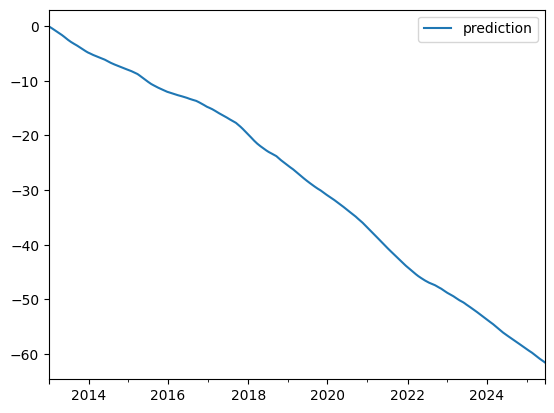

In [13]:
alpha_scores = pd.DataFrame(alpha_scores).rename(columns={"prediction": "alpha"}).T
alpha_scores.cumsum().plot()

We can see that a basic model trained on our dataset has okay performance, but it starts to level out toward the end. If we calculate the sharpe of these scores we see it's pretty low (the 10-year sharpe of the S&P500 is about 0.6):

In [14]:
alpha_scores.mean() / alpha_scores.std()

prediction   -3.524938
dtype: float64

This is because our basic features and factors are really only useful to **remove** exposures to them, not rely on them for prediction - this is why you must bring your own data sources to Numerai Signals. We leave it as an exercise to the reader to gather data and train a model to be aware of the neutralization and the sample-weighting data. The goal should be to produce a model with good alpha.

For now, let's continue with how to structure your live submission.

# Live Submission

To make a live submission, you only need to submit a ticker column with its signal.

We accept the following tickers for live submissions:

* cusip
* sedol
* bloomberg_ticker
* composite_figi
* numerai_ticker

In [15]:
napi.download_dataset(f'signals/{DATASET_VERSION}/live.parquet')
live = pd.read_parquet(f'signals/{DATASET_VERSION}/live.parquet')

live['signal'] = model.predict(live[feature_cols])

submission = live[['numerai_ticker', 'signal']]
submission

2025-09-26 16:22:33,401 INFO numerapi.utils: target file already exists


2025-09-26 16:22:33,403 INFO numerapi.utils: download complete


,numerai_ticker,signal
0,000080 KR,0.536028
1,000100 KR,0.433998
2,000120 KR,0.491001
3,000150 KR,0.458877
4,000210 KR,0.510601
...,...,...
7147,ZURN CH,0.461136
7148,ZVRA US,0.431151
7149,ZWS US,0.447453
7150,ZYME US,0.426464


In [16]:
# Save and download your predictions
filename = f'signals_example_preds.csv'
from numerai_tools.scoring import tie_kept_rank
submission[['signal']] = tie_kept_rank(submission[['signal']])
submission.to_csv(filename, index=False)

# Download file if running in Google Colab
try:
    from google.colab import files
    files.download(filename)
except:
    pass

/var/folders/vm/jlf_h6td3b5dh_kg5p3xr45c0000gq/T/ipykernel_67452/1415450786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission[['signal']] = tie_kept_rank(submission[['signal']])




Now you can visit the [Submissions page](https://signals.numer.ai/submissions) to submit these predictions to your model. Once you submit, your predictions will begin scoring approximately 1 week later. Your final scores will be computed depending on the score - for example, Alpha is a 60D (or 60 business day) score, so it resolves approximately 13 weeks after you submit.
